# End to end image blurness and sharpness detection

```
Project description:

This project has three categories to detect:

* defocused blur
* motion blured
* sharp

```

## Installing a library used to split the folder into train and test directories

In [ ]:
!pip install split-folders

## Splitting the folder

In [ ]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/blurness_and_sharpness_detection_data/data",
                   seed=42,
                   output="/content/data",
                   ratio=(.8,.2))

Copying files: 1050 files [00:34, 30.35 files/s] 


## Importing the `Helper functions` from github

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-15 12:53:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-15 12:53:55 (42.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Initiating trainig and testing directories

In [ ]:
train_dir="/content/data/train"
test_dir="/content/data/val"

## Preprocessing the images for model building 

### This priocessing consists of:

* Data Augmentation
* Rescaling the data 
* Zooming the Images
* Shifting the range of height and width by 0.2

In [ ]:
import tensorflow as tf
IMG_SIZE=(224,224)
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              rotation_range=40,
                                                              horizontal_flip=True,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2,
                                                              shear_range=0.2,
                                                              zoom_range=0.2,
                                                              fill_mode="nearest")

train_generator=train_datagen.flow_from_directory(train_dir,
                                                  subset="training",
                                                  shuffle=True,
                                                  seed=42,
                                                  color_mode="rgb",
                                                  class_mode="categorical",
                                                  target_size=IMG_SIZE,
                                                  batch_size=64)

Found 840 images belonging to 3 classes.


In [ ]:
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_directory(test_dir,
                                                shuffle=True,
                                                seed=42,
                                                color_mode="rgb",
                                                class_mode="categorical",
                                                target_size=IMG_SIZE,
                                                batch_size=64)

Found 210 images belonging to 3 classes.


## Building model3

The below model has been built using Functional API, which consists of a `Feature Vectoerizer` layer which has been loaded from tensorflos hub

In [ ]:
import tensorflow_hub as hub
IMG_SIZE=(224,224)
feature_vectorizer2=hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/placental/1",
                                  input_shape=IMG_SIZE+(3,))

In [ ]:
inputs=tf.keras.layers.Input(shape=(224,224,3))
x=feature_vectorizer2(inputs)
x=tf.keras.layers.Flatten()(x)
# x=tf.keras.layers.Dense(256,activation="relu")(x)
x=tf.keras.layers.Dense(512,activation="relu")(x)
# x=tf.keras.layers.MaxPool2D()(x)
x=tf.keras.layers.Dense(256,bias_initializer='ones',activation="relu")(x)
# x=tf.keras.layers.Conv2D(100,3,activation="relu")(x)
x=tf.keras.layers.Dense(128,activation="relu")(x)
x=tf.keras.layers.Dense(64,activation="relu")(x)
# x=tf.keras.layers.Dense(32,activation="relu")(x)
x=tf.keras.layers.Dropout(0.2)(x) 
outputs=tf.keras.layers.Dense(train_generator.num_classes,activation="softmax")(x)
model=tf.keras.Model(inputs,outputs)

model.compile(loss="categorical_crossentropy",
metrics=["accuracy"],
optimizer="adam")

history=model.fit(train_generator,
                      epochs=10,
                      steps_per_epoch=train_generator.samples//train_generator.batch_size,
                      validation_data=test_generator,
                      validation_steps=test_generator.samples//test_generator.batch_size)
                      # callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=7, restore_best_weights=True),
                      # tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

Epoch 1/10
13/13 [==============================] - 95s 5s/step - loss: 2.2775 - accuracy: 0.4240 - val_loss: 0.7291 - val_accuracy: 0.6823
Epoch 2/10
13/13 [==============================] - 60s 5s/step - loss: 0.8603 - accuracy: 0.5954 - val_loss: 0.5181 - val_accuracy: 0.8125
Epoch 3/10
13/13 [==============================] - 60s 5s/step - loss: 0.7071 - accuracy: 0.6856 - val_loss: 0.5556 - val_accuracy: 0.7969
Epoch 4/10
13/13 [==============================] - 60s 5s/step - loss: 0.5590 - accuracy: 0.7539 - val_loss: 0.5216 - val_accuracy: 0.7760
Epoch 5/10
13/13 [==============================] - 60s 5s/step - loss: 0.6460 - accuracy: 0.7307 - val_loss: 0.4382 - val_accuracy: 0.8490
Epoch 6/10
13/13 [==============================] - 60s 5s/step - loss: 0.5362 - accuracy: 0.7796 - val_loss: 0.3953 - val_accuracy: 0.8281
Epoch 7/10
13/13 [==============================] - 61s 5s/step - loss: 0.4341 - accuracy: 0.8196 - val_loss: 0.4346 - val_accuracy: 0.8281
Epoch 8/10
13/13 [==

## Saving the best model

In [ ]:
model.save("Model3_Feature_vectorizer.h5")

## Making a function for final testing of the model on the images

The below functions helps to:
* Load the image 
* Decode the image into tensors
* And resize the image

In [ ]:
# Create a function to import an image and resize it tbe able to be used with our model
import tensorflow as tf
def load_and_prep_image(filename,img_shape=224):
  """
  Reads an image from the filename, turns it into a tensor and reshape it,
  to (img_shape,img_shape,color channels)
  """
  # Read in the image 
  img=tf.io.read_file(filename)

  # brightness(img)
  # Decode the read file into a tensor
  img=tf.image.decode_image(img)
  # Resize the image
  img=tf.image.resize(img,size=[img_shape,img_shape])
  # Resacle the image and resacale all the values between 0 and 1 
  img=img/255.

  return img

### Listing the `CLASS NAMES`

In [ ]:
class_names=["defocused_blur","motion_blur","sharp"]

## Building a Function for plotting the predicted image with its class name

In [ ]:
from PIL import Image,ImageStat

def brightness( im_file ):
   im = Image.open(im_file)
   stat = ImageStat.Stat(im)
   r,g,b = stat.mean
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
def pred_and_plot(model,filename,class_names=class_names):
  # Import the target image and preprocess it.
  
  img=load_and_prep_image(filename)
  img = tf.convert_to_tensor(img[:,:,:3])
  # brightness(img)
  # Make predictions 
  # Brightness Calculator

  im=Image.open(filename)
  stat = ImageStat.Stat(im)
  r,g,b = stat.mean
  val=math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))
  
  print(f"The Exposure value of the image is: {val:.2f}")

  pred=model.predict(tf.expand_dims(img,axis=0))

  # Get the predicted class
  pred_class=class_names[int(np.argmax((tf.round(pred))))]

  # print(pred_class)
  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"prediction: {pred_class}")
  plt.axis(False);

  if(pred_class=="defocused_blur" or pred_class=="motion_blur"):
    print("The Given Image is blur please retake the image")

## Loading the saved model for predictions

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
loaded_model=tf.keras.models.load_model('/content/Model3_Feature_vectorizer.h5',custom_objects={'KerasLayer':hub.KerasLayer})

The Exposure value of the image is: 156.60


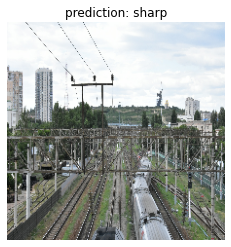

In [ ]:
pred_and_plot(loaded_model,"/content/data/train/sharp/132_NIKON-D3400-18-55MM_S.JPG")

The Exposure value of the image is: 15.17
The Given Image is blur please retake the image


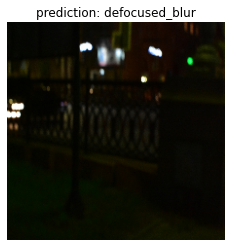

In [ ]:
pred_and_plot(loaded_model,"/content/data/val/defocused_blurred/102_NIKON-D3400-35MM_F.JPG")

The Exposure value of the image is: 47.41
The Given Image is blur please retake the image


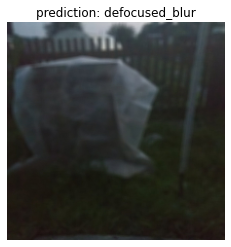

In [ ]:
pred_and_plot(loaded_model,"/content/data/val/defocused_blurred/233_XIAOMI-REDMI-4_F.jpg")

In [ ]:
model.save("Model3_Feature_vectorizer.h5")

In [ ]:
!pip install gradio

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import gradio

# model=tf.keras.models.load_model("/content/Model3_Feature_vectorizer.h5",custom_objects={'KerasLayer':hub.KerasLayer})
def grd(img):
    img = img.reshape(-1, 224,224, 3)
    prediction = loaded_model.predict(img).tolist()[0]
    class_names = ["defocused_blurred", "motion_blurred",'sharp']
    return {class_names[i]: prediction[i] for i in range(3)}
#set the user uploaded image as the input array
#match same shape as the input shape in the model
im = gradio.inputs.Image(shape=(224,224))
#setup the interface
iface = gradio.Interface(
    fn = grd, 
    inputs = im, 
    outputs = gradio.outputs.Label(num_top_classes=3),
)
iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://25249.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


In [ ]:
from PIL import Image,ImageStat
import math
def brightness( im_file ):
   im = Image.open(im_file)
   stat = ImageStat.Stat(im)
   r,g,b = stat.mean
   val=math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))
   print(f"The exposure of the image is: {val}")

In [ ]:
import cv2
# img=cv2.imread("/content/sp.jpg")
brightness("/content/data/val/motion_blurred/113_SAMSUNG-GALAXY-A5_M.jpg")

## Converting a model to tflite

In [ ]:
model.save("feature_vectorized_model")

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/feature_vectorized_model") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('blur_sharp_detector.tflite', 'wb') as f:
  f.write(tflite_model)